# Importing Libraries and Tensorflow<a class="anchor" id="importing"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra,math functions
import tensorflow as tf # tensorflow
import random # for seed value
import os # for folder functions
import string # for making alphabet labels as string
import pandas as pd # data processing
%matplotlib inline
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
for dirname, _, filenames in os.walk('/kaggle/input'): # default
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


In [ ]:
seed=42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# We are using random seeds for controlling randomness.

<hr>

# Data Preprocessing<a class="anchor" id="preprocess"></a>

In [ ]:
train_data=pd.read_csv("../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_data=pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
print("Shape of train_data: ",train_data.shape,"Shape of test_data: ",test_data.shape)

Shape of train_data:  (27455, 785) Shape of test_data:  (7172, 785)


In [ ]:
strlabels=list(string.ascii_uppercase) # Appending alphabet to a list.
strlabels.remove("J") # Removing J letter because of the hand gesture problem.
print(strlabels) # Making a new list that contains letters for each indices.

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
train_labels=train_data["label"]
train_images=train_data.drop("label",axis=1).values # Dropping labels axis=1 > all column (axis=0 is all row)
test_labels=test_data["label"]
test_images=test_data.drop("label",axis=1).values # Dropping Labels axis=1 > all column (axis=0 is all row)
                                               
train_images=train_images/255.0 # We are scaling our pixels between 0 and 1 for the sake of computing performance.
test_images=test_images/255.0

train_images=train_images.reshape(-1,28,28,1) # Reshaping for making images ready to go.
test_images=test_images.reshape(-1,28,28,1)
print(train_images.shape) # We have 27.455 images as 28x28x1 (2D Image with one channel)

(27455, 28, 28, 1)


## Countplot of Labels<a class="anchor" id="countplot"></a>

[Text(0, 0.5, 'Test Images'), Text(0.5, 0, 'Test Labels')]

<Figure size 640x480 with 0 Axes>

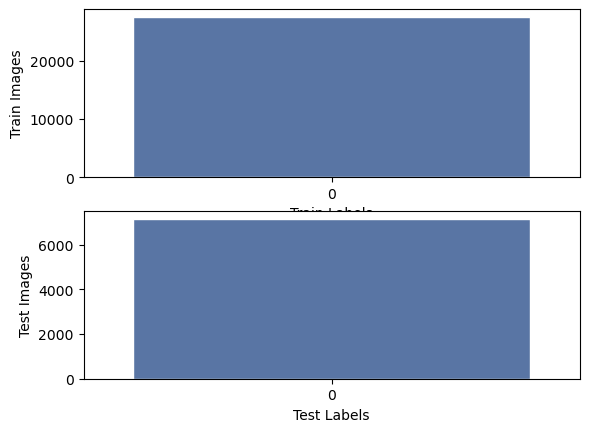

In [ ]:
plt.figure() # Matplotlib for visualization.
plt.tight_layout() # Wide space for images.
fig,ax=plt.subplots(2,1) # Making space for 2 rows and 4 images for each row.
sns.set(rc={'figure.figsize':(15,5)}) # Size of images.
sns.countplot(train_labels,ax=ax[0])
ax[0].set(ylabel="Train Images", xlabel = "Train Labels") # Setting labels.
sns.countplot(test_labels,ax=ax[1])
ax[1].set(ylabel="Test Images", xlabel = "Test Labels") # Setting labels.

## First 8 Samples<a class="anchor" id="firsteight"></a>

<Figure size 1500x500 with 0 Axes>

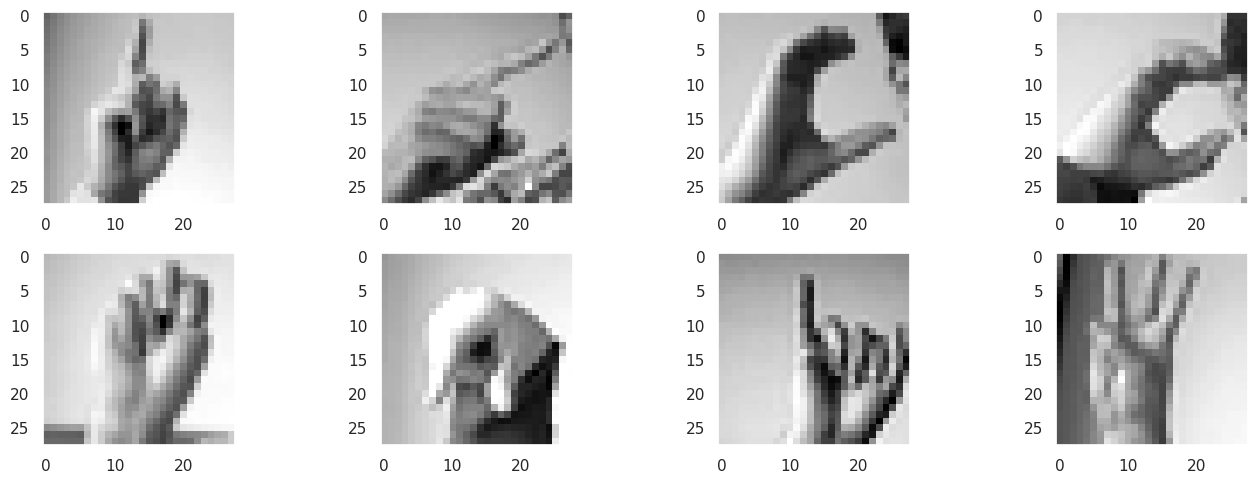

In [ ]:
plt.figure() # Matplotlib for visualization.
f, graph = plt.subplots(2,4) # Making space for 2 rows and 4 images for each row.
f.set_size_inches(14, 5) # Size of images.
z=0
for i in range(2): # i for rows
    for k in range(4): # k for columns
        graph[i][k].imshow(train_images[z].reshape(28,28),cmap="gray") # Showing each train image.
        graph[i][k].grid(False) # Removing grids for each train image.
        z+=1
plt.tight_layout() # Wide space for images.
plt.show()

<hr>

# Building Model<a class="anchor" id="model"></a>

## Data Augmentation<a class="anchor" id="augmentation"></a>

In [ ]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
generator.fit(train_images)
# We use ImageDataGenerator for changing images randomly and train our model better.

## Callbacks<a class="anchor" id="callbacks"></a>

In [ ]:
acc_treshold = 1.0 # Accuracy treshold.
class myCallback(tf.keras.callbacks.Callback):
    epc=0
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') >= acc_treshold-0.0100 and logs.get('val_acc') >= acc_treshold):
            print("\nReached %2.2f%% accuracy !" %(logs.get('val_acc')*100)) # Printing accuracy as percentage.
            self.model.stop_training = True
            self.epc=epoch+1
callbacks = myCallback()
# We are using callbacks because we want to shut our training process down when it learns 100%.

## Building CNN Model<a class="anchor" id="cnn"></a>

In [ ]:
model=tf.keras.Sequential([ # Using tf.keras for build our sequential.
    tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu",input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2),strides=2),
    
    tf.keras.layers.Dropout(0.2), # Dropping random 2% data out for learning variety.
    
    tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2),strides=2),
    
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25,activation="softmax")
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),loss="sparse_categorical_crossentropy",metrics=["acc"])
model.summary() # Summary of our model.
epochs=80
history=model.fit(generator.flow(train_images,train_labels,batch_size=128),epochs=epochs,callbacks=[callbacks],validation_data=(test_images,test_labels),verbose=1)
# generator.flow() for applying data augmentation.
test_loss,test_acc=model.evaluate(test_images,test_labels)
print("test acc:",test_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       1

2023-06-02 11:33:56.801214: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


215/215 [==============================] - 27s 51ms/step - loss: 2.5378 - acc: 0.2493 - val_loss: 3.3151 - val_acc: 0.0431
Epoch 2/80
215/215 [==============================] - 10s 47ms/step - loss: 1.3984 - acc: 0.5491 - val_loss: 2.5346 - val_acc: 0.1930
Epoch 3/80
215/215 [==============================] - 11s 50ms/step - loss: 0.9173 - acc: 0.6948 - val_loss: 0.7809 - val_acc: 0.7545
Epoch 4/80
215/215 [==============================] - 10s 47ms/step - loss: 0.6862 - acc: 0.7689 - val_loss: 0.9987 - val_acc: 0.6405
Epoch 5/80
215/215 [==============================] - 10s 47ms/step - loss: 0.5382 - acc: 0.8190 - val_loss: 0.3819 - val_acc: 0.8606
Epoch 6/80
215/215 [==============================] - 11s 50ms/step - loss: 0.4330 - acc: 0.8547 - val_loss: 0.2268 - val_acc: 0.9290
Epoch 7/80
215/215 [==============================] - 10s 47ms/step - loss: 0.3634 - acc: 0.8795 - val_loss: 0.2324 - val_acc: 0.9175
Epoch 8/80
215/215 [==============================] - 10s 47ms/step - los

In [ ]:
prediction=model.predict(test_images) # Making predictions of test images with our model.


225/225 [==============================] - 1s 2ms/step


## Plot of Progress<a class="anchor" id="progress"></a>

<Figure size 1500x500 with 0 Axes>

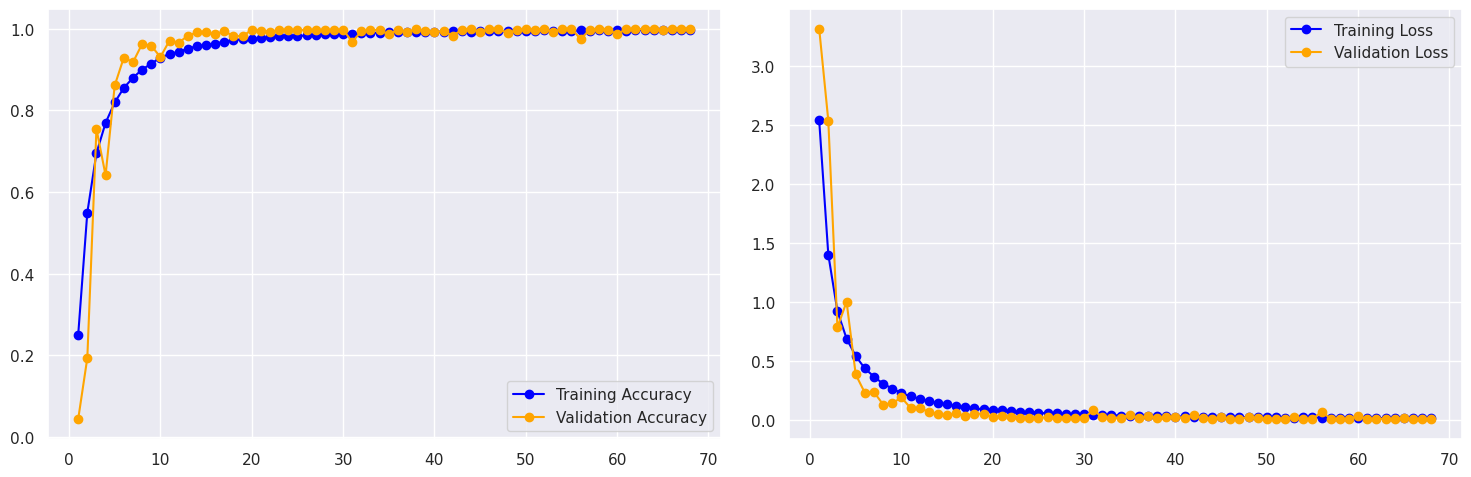

In [ ]:
epoch_range=range(1,callbacks.epc+1 if callbacks.epc != 0 else epochs) # Epoch range for plotting our x-axis.
plt.figure() # Matplotlib for visualization.
f, ax = plt.subplots(1,2) # Making space for 2 rows and 4 images for each row.
fig.set_size_inches(30, 5) # Size of images.
plt.tight_layout() # Wide space for images.
ax[0].plot(epoch_range,history.history["acc"],color="blue",marker="o")
ax[0].plot(epoch_range,history.history["val_acc"],color="orange",marker="o")
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
ax[1].plot(epoch_range,np.array(history.history["loss"]),color="blue",marker="o")
ax[1].plot(epoch_range,np.array(history.history["val_loss"]),color="orange",marker="o")
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [ ]:
predictions=[]
test_labels_string=[]
for i in range(0,test_labels.size):
    predictions.append(strlabels[np.argmax(prediction[i])]) # np.argmax() for taking highest value among the others.
    test_labels_string.append(strlabels[test_labels[i]])
# Converting predictions to letters.

## Confusion Matrix for Checking Results<a class="anchor" id="confusion"></a>

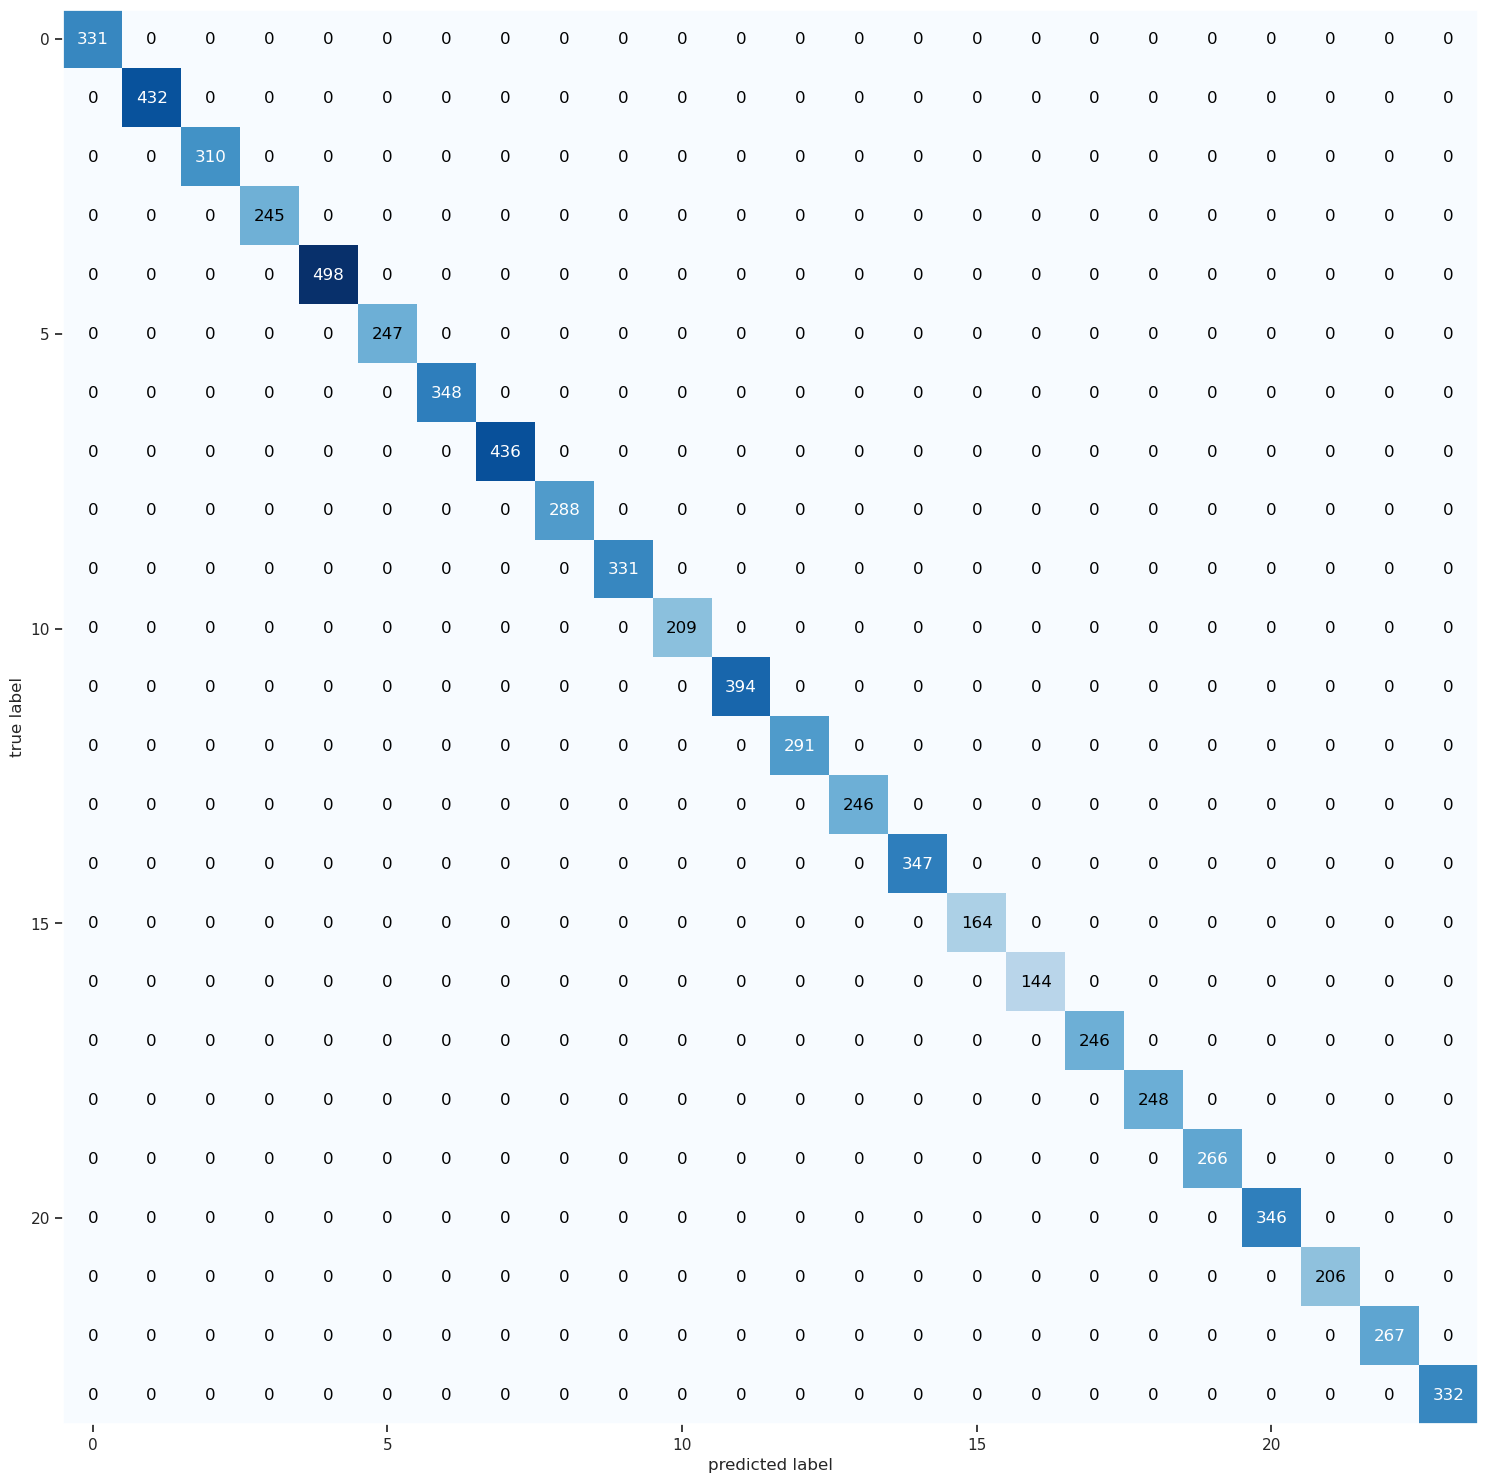

In [ ]:
from sklearn.metrics import confusion_matrix # Sklearn for making confusion matrix.
from mlxtend.plotting import plot_confusion_matrix # Mlxtend for plotting confusion matrix.
cf=confusion_matrix(predictions,test_labels_string)
fig, ax = plot_confusion_matrix(conf_mat=cf)
fig.set_size_inches(15, 15) # Size of image.
plt.tight_layout() # Wide space for image.
plt.show()

<hr>

# Testing<a class="anchor" id="testing"></a>

Predicted letter is: H 
True Answer: H


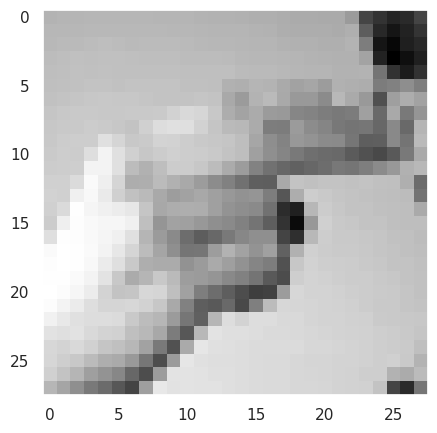

In [ ]:
n=9
plt.imshow(test_images[n].reshape(28,28),cmap="gray") # Showing images
plt.grid(False) # Removing grid for each image.
print("Predicted letter is:",predictions[n],"\nTrue Answer:",test_labels_string[n]) # Prediction - True Answer